# Extraction of spectra and images for I16293
Leonardo Testi - 23-May-2016


In [1]:
#
# Extract spectra of source a and b in the i16293 ALMA data

import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits as aiof
from spectral_cube import SpectralCube
import pyregion
import astropy.units as u
from astropy.coordinates import SkyCoord
import aplpy
import os

%matplotlib inline 
matplotlib.rcParams['axes.linewidth'] = 2.5
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 20

## Definition of the regions for spectra
Here I define the regions used to extract the spectra for sources "a" and "b". Note: source "a" is the one with the broad lines, while source "b" is the narrow lines hot corino. In both cases, for simplicity, I am extracting spectra on circular apertures. This can be changed/adapted.

In [2]:
def get_ss_reg(src):
    sa = str(int(src.ra.hms[0]))+':'+str(int(src.ra.hms[1]))+':'+str(src.ra.hms[2])
    if source_a.dec.deg <0:
        sd='-'+str(int(abs(src.dec.dms[0])))+':'+str(int(abs(src.dec.dms[1])))+':'+str(abs(src.dec.dms[2]))
    else:
        sd=str(int(abs(src.dec.dms[0])))+':'+str(int(abs(src.dec.dms[1])))+':'+str(abs(src.dec.dms[2]))
    #
    return sa+', '+sd
    
# regions
source_a = SkyCoord('16:32:22.879 -24:28:36.468', unit=(u.hourangle, u.deg))
rad_a = 0.7*u.arcsec
source_b = SkyCoord('16:32:22.607 -24:28:32.559', unit=(u.hourangle, u.deg))
rad_b = 0.5*u.arcsec

#a_reg = pyregion.parse("FK5; circle("+source_a+","+str(rad_a.to(u.degree).value)+")")
a_reg = pyregion.parse("FK5; circle("+get_ss_reg(source_a)+","+str(rad_a.to(u.degree).value)+")")

#b_reg = pyregion.parse("FK5; circle("+source_b+","+str(rad_b.to(u.degree).value)+")")
b_reg = pyregion.parse("FK5; circle("+get_ss_reg(source_b)+","+str(rad_b.to(u.degree).value)+")")

## Check continuum subtraction
This one below is just a consistency check that continuum subtration was achieved successfully in one of the most difficult bands.

Working on /Volumes/LT_Portable/iras_16293/img_00278/cube_cln_00278_ACA_338_spw0.fits
Converged after 17 loops
Converged after 23 loops
Working on /Volumes/LT_Portable/iras_16293/img_00278/cube_cln_00278_ACA_338_spw1.fits
Converged after 32 loops
Converged after 20 loops
Working on /Volumes/LT_Portable/iras_16293/img_00278/cube_cln_00278_ACA_338_spw2.fits
Converged after 22 loops
Converged after 19 loops
Working on /Volumes/LT_Portable/iras_16293/img_00278/cube_cln_00278_ACA_338_spw3.fits
Converged after 14 loops
Converged after 31 loops


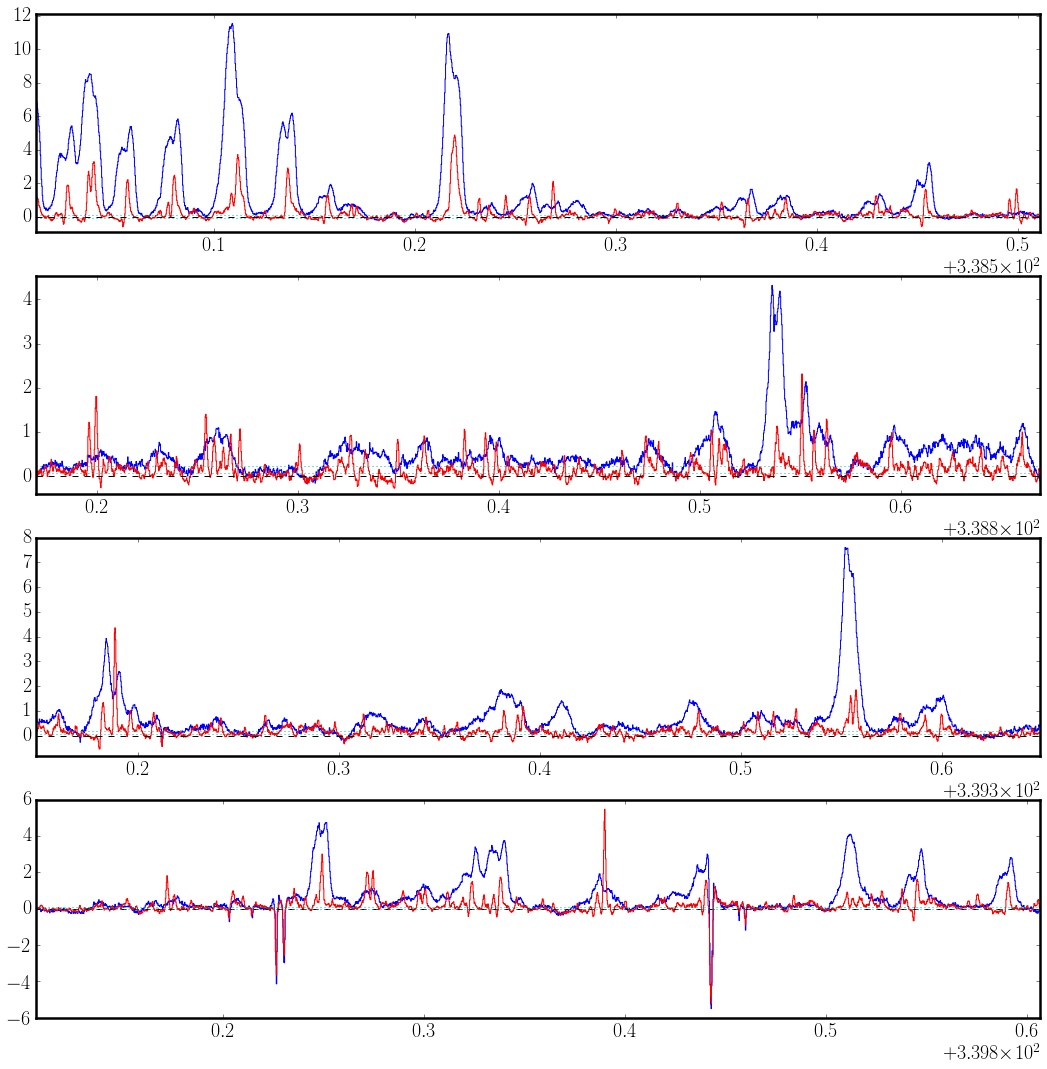

In [17]:
# datafiles
myproj = '00278'
setting = 'ACA_338'
mydir = '/Volumes/LT_Portable/iras_16293/img_'+myproj+'/'
#mydir = '/Users/ltesti/Desktop/Dropbox/i16293_cubes/'

#cubes_nam = mydir+'cube_cln_00712_250_spw'
#cubes_nam = mydir+'cube_cln_00712_240_spw'
#cubes_nam = mydir+'cube_cln_00712_090_spw'
cubes_nam = mydir+'cube_cln_'+myproj+'_'+setting+'_spw'

#spws = ['0','1','2','3','5','6','7','8']
spws = ['0','1','2','3']

# frequencies
c = 2.998e5*u.km/u.s
dv = 2.5*u.km/u.s
restfreq = np.array([139631.255, 232342.227, 232411.044, 240302.835, 250313.498, 250323.521, 250676.14])*u.MHz
obsfreq = restfreq*(1.-dv/c)

#
# Function to identify cont chan
def get_cont_ch(myspec, doplot=False):
        
    def get_nn(yy,y):
        s = np.std(yy)
        m = np.median(yy)
        return np.where((y<(m+1.55*s))&(y>(m-2.5*s)))

    x = np.linspace(0,len(myspec),len(myspec))
    yy = np.copy(myspec)
    ylo = len(yy)
    ni = 0
    nmax = 200
    if doplot:
        plt.plot(xa,myspec,color='b')
    while True:
        nn = get_nn(yy,myspec)
        yy = np.copy(myspec[nn])
        yl = len(yy)
        ni=ni+1
        if (yl == ylo):
            print("Converged after {0} loops".format(ni))
            break
        ylo = yl
        if (ni >= nmax):
            print("Reached max iterations: {0} loops".format(ni))
            break
    if doplot:
        plt.plot(x[nn],myspec[nn],color='r')
    
    return nn


fig, ax = plt.subplots(len(spws), 1, sharex=False, sharey=False, squeeze=True, figsize=(18,4.5*len(spws)))

nc=0
nu0=250313.498*u.MHz
plotnu=True
for myspw in spws:
    mycube = cubes_nam+myspw+'.fits'
    print('Working on {0}'.format(mycube))

    # read cube
    cube = SpectralCube.read(mycube)
    sca = cube.subcube_from_ds9region(a_reg)
    scb = cube.subcube_from_ds9region(b_reg)
    if plotnu:
        scag = sca.with_spectral_unit(u.GHz)
        scbg = scb.with_spectral_unit(u.GHz)
    else:
        scag = sca.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=nu0)
        scbg = scb.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=nu0)
    #print("nu0={0}".format(nu0))    
    #

    #ya = np.nanmean(np.nanmean(scag.filled_data[:,:,:],axis=1),axis=1).value
    ya = scag.mean(axis=(1,2)).value
    xa = np.linspace(0,len(ya),len(ya))
    #yb = np.nanmean(np.nanmean(scbg.filled_data[:,:,:],axis=1),axis=1).value
    specb = scbg.mean(axis=(1,2))
    os.system('rm '+mycube[0:-5]+'_specb.fits')
    specb.hdu.writeto(mycube[0:-5]+'_specb.fits')
    yb = specb.value
    xb = np.linspace(0,len(yb),len(yb))
    
    nna=get_cont_ch(ya)
    nnb=get_cont_ch(yb)
    ca=np.mean(ya[nna])
    cb=np.mean(yb[nnb])

    xmin=np.min(scag.spectral_axis.value)
    xmax=np.max(scag.spectral_axis.value)
    ymina=np.min(ya)-0.05*(np.max(ya)-np.min(ya))
    ymaxa=np.max(ya)+0.05*(np.max(ya)-np.min(ya))
    yminb=np.min(yb)-0.05*(np.max(yb)-np.min(yb))
    ymaxb=np.max(yb)+0.05*(np.max(yb)-np.min(yb))
    ymin = np.min([ymina,yminb])
    ymax = np.max([ymaxa,ymaxb])

    #ax[nc].step(scag.spectral_axis,ya-ca,color='b')
    #ax[nc].step(scbg.spectral_axis,yb-cb,color='r')
    ax[nc].step(scag.spectral_axis,ya,color='b')
    #ax[nc].step(scag.spectral_axis,yab.value,color='c')
    ax[nc].step(scbg.spectral_axis,yb,color='r')
    ax[nc].plot([xmin,xmax],[0.,0.],linestyle='dashed',color='k')
    ax[nc].plot([xmin,xmax],[ca,ca],linestyle='dotted',color='c')
    ax[nc].plot([xmin,xmax],[cb,cb],linestyle='dotted',color='c')

    for nu in restfreq:
        ax[nc].plot([((nu.to(u.GHz))*(1.-dv/c)).value,((nu.to(u.GHz))*(1.-dv/c)).value],[0,0.3],color='g',linestyle='dashed')
        ax[nc].plot([(c*(nu0-nu)/nu0+dv).value,(c*(nu0-nu)/nu0+dv).value],[0,0.3],color='g',linestyle='dashed')
    ax[nc].set_xlim(xmin,xmax)
    ax[nc].set_ylim(ymin,ymax)
    nc=nc+1

fig.savefig(cubes_nam+'.pdf')

# Identify in which cubes we have the lines of interest
In this block we match the frequency of the transitions of interst with the available cubes, so that we only consider the matched cubes-frequencies in the following analysis.

In [11]:
debug = False
verbose = True

projs = [['00712',['090','240','250'],[['0','1','2','3'],['0','1','2','3'],['0','1','2','3']]],
         ['00352',['140','250'],[['0','1','3'],['0','1','2','3','5','6','7','8']]],
         ['00061',['225'],[['0','2','3','4','5']]],
         ['00018',['330','335'],[['0','1','2'],['0','2']]],
         ['band4sv',['140'],[['0'],]],
         ['band6sv',['220'],[['0'],]],
         ['band9sv',['688'],[['0','1','2','3'],]],
        ]
mydir = '/Users/ltesti/Desktop/Dropbox/i16293_cubes/'
mydir = '/Volumes/LT_Portable/iras_16293/img_'

restfreq = np.array([79.90329, 119.85367, 159.80253, 199.74942, 239.69367, 279.63494, 319.57266, 359.50635, 399.43546])*u.GHz
restfreq = np.array([139631.255, 157000.493, 157258.419, 157259.087, 232342.227, 232411.044, 240302.835, 240381.664, 240418.979, 250313.498, 250323.521, 250676.14])*u.MHz

matched_transcube=[]

#
# Matching transitions to cubes
for proj in projs:
    for iset in range(len(proj[1])):
        cubes_nam = mydir+proj[0]+'/'+'cube_cln_'+proj[0]+'_'+proj[1][iset]+'_spw'
        for ispw in range(len(proj[2][iset])):
            mycube = cubes_nam+proj[2][iset][ispw]+'.fits'
            if debug:
                print("Reading cube: {0}".format(mycube))
            cube = (SpectralCube.read(mycube)).with_spectral_unit(u.MHz)
            numin = np.min(cube.spectral_axis.value)
            numax = np.max(cube.spectral_axis.value)
            for rf in restfreq:
                if ((rf.value >= numin) & (rf.value <= numax)):
                    if debug:
                        print("       matched with transition: {0}".format(rf))
                    matched_transcube.append([mycube, rf])
#
# Check matched transitions
if verbose:
    if debug:
        print("Matched {0} transitions-cubes".format(len(matched_transcube)))
    for mt in matched_transcube:
        print("{0}, {1}".format(mt[0],mt[1]))

#
#


/Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_240_spw1.fits, 240302.835 MHz
/Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_240_spw1.fits, 240381.664 MHz
/Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_240_spw1.fits, 240418.979 MHz
/Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_250_spw1.fits, 250313.498 MHz
/Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_250_spw1.fits, 250323.521 MHz
/Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_250_spw1.fits, 250676.14 MHz
/Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_250_spw3.fits, 232342.227 MHz
/Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_250_spw3.fits, 232411.044 MHz
/Volumes/LT_Portable/iras_16293/img_00352/cube_cln_00352_140_spw0.fits, 139631.255 MHz
/Volumes/LT_Portable/iras_16293/img_band4sv/cube_cln_band4sv_140_spw0.fits, 157000.493 MHz
/Volumes/LT_Portable/iras_16293/img_band4sv/cube_cln_band4sv_140_spw0.fits, 157258.419 MHz
/Volumes/LT_Portable/iras_16293/img_

# Plot spectra for source b
Here we plot a small portion of the spectrum around the position of source b.
This helps checking the continuum subtraction around each line and to double check the channels selected for the moment images. The script can plot either in velocity or frequency, depending on the value of plnu.

In [8]:
def draw_panel(filename,figure,location,colormap,vmin,vmax,fig_center,fig_FOV,fontsize=45,text=''):
    subfig = aplpy.FITSFigure(filename, figure=figure, subplot=location)
    subfig.show_colorscale(cmap=colormap, vmin=vmin, vmax=vmax)
    #subfig.show_grayscale(vmin=vmin, vmax=vmax)
    #subfig.show_contour(filename, levels=levels, colors=contour_color)
    subfig.recenter(fig_center[0], fig_center[1], width=fig_FOV[0], height=fig_FOV[1]) 
            
    # beam
    #subfig.add_beam()
    #subfig.beam.set(color='gray', alpha=0.8)

    # ticks
    subfig.ticks.show()
    subfig.ticks.set_length(14) # points
    subfig.ticks.set_color('black')
    subfig.ticks.set_linewidth(1.)  # points
    subfig.ticks.set_minor_frequency(5) # ratio minor ticks per major tick
    subfig.tick_labels.set_font(size=fontsize, weight='normal')     
    subfig.ticks.set_xspacing(0.00075)
    # axes
    subfig.axis_labels.set_ypad(-20)
    subfig.axis_labels.set_xpad(7)
    subfig.axis_labels.set_font(size=fontsize, weight='normal') 

    # frame
    subfig.frame.set_linewidth(1.)

    # add text label
    # subfig.add_label(fig_center[0]+0.65*fig_FOV[0]/2., fig_center[1]+0.8*fig_FOV[1]/2., text, relative=False, size=50)
    subfig.add_label(0.5, 0.9, text, weight='bold', relative=True, size=fontsize*2)
    
    #
    # Colorbar
    subfig.add_colorbar()
    subfig.colorbar.set_location('right')
    subfig.colorbar.show()
    
    # beam
    #subfig.add_beam()
    #subfig.beam.set_corner('bottom left')
    #subfig.beam.set_color('yellow')
    #subfig.beam.set_edgecolor('yellow')
    #subfig.beam.set_facecolor('yellow')
    #subfig.beam.set_linewidth(2.)
    #subfig.beam.set_hatch('0')
    #subfig.beam.set_alpha(1.0)
    #subfig.beam.set(color='yellow', linewidth=2., linestyle='solid', )
    #subfig.beam.show()
        
    return subfig


center: [248.09419583333332, -24.47571083333333]
   fov: [0.001388888888888889, 0.001388888888888889]
Using: /Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_240_spw1.fits, 240302.835 MHz


/Users/ltesti/anaconda/lib/python2.7/site-packages/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))
/Users/ltesti/anaconda/lib/python2.7/site-packages/spectral_cube/_moments.py:179: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))
/Users/ltesti/anaconda/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:
/Users/ltesti/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/ltesti/anaconda/lib/python2.7/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


Using: /Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_240_spw1.fits, 240381.664 MHz
Using: /Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_240_spw1.fits, 240418.979 MHz
Using: /Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_250_spw1.fits, 250313.498 MHz
Using: /Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_250_spw1.fits, 250323.521 MHz
Using: /Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_250_spw1.fits, 250676.14 MHz
Using: /Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_250_spw3.fits, 232342.227 MHz
Using: /Volumes/LT_Portable/iras_16293/img_00712/cube_cln_00712_250_spw3.fits, 232411.044 MHz
Using: /Volumes/LT_Portable/iras_16293/img_00352/cube_cln_00352_140_spw0.fits, 139631.255 MHz
Using: /Volumes/LT_Portable/iras_16293/img_band4sv/cube_cln_band4sv_140_spw0.fits, 157000.493 MHz
Using: /Volumes/LT_Portable/iras_16293/img_band4sv/cube_cln_band4sv_140_spw0.fits, 157258.419 MHz
Using: /Volumes/LT_Portable/iras_16293/img_band4sv/cu

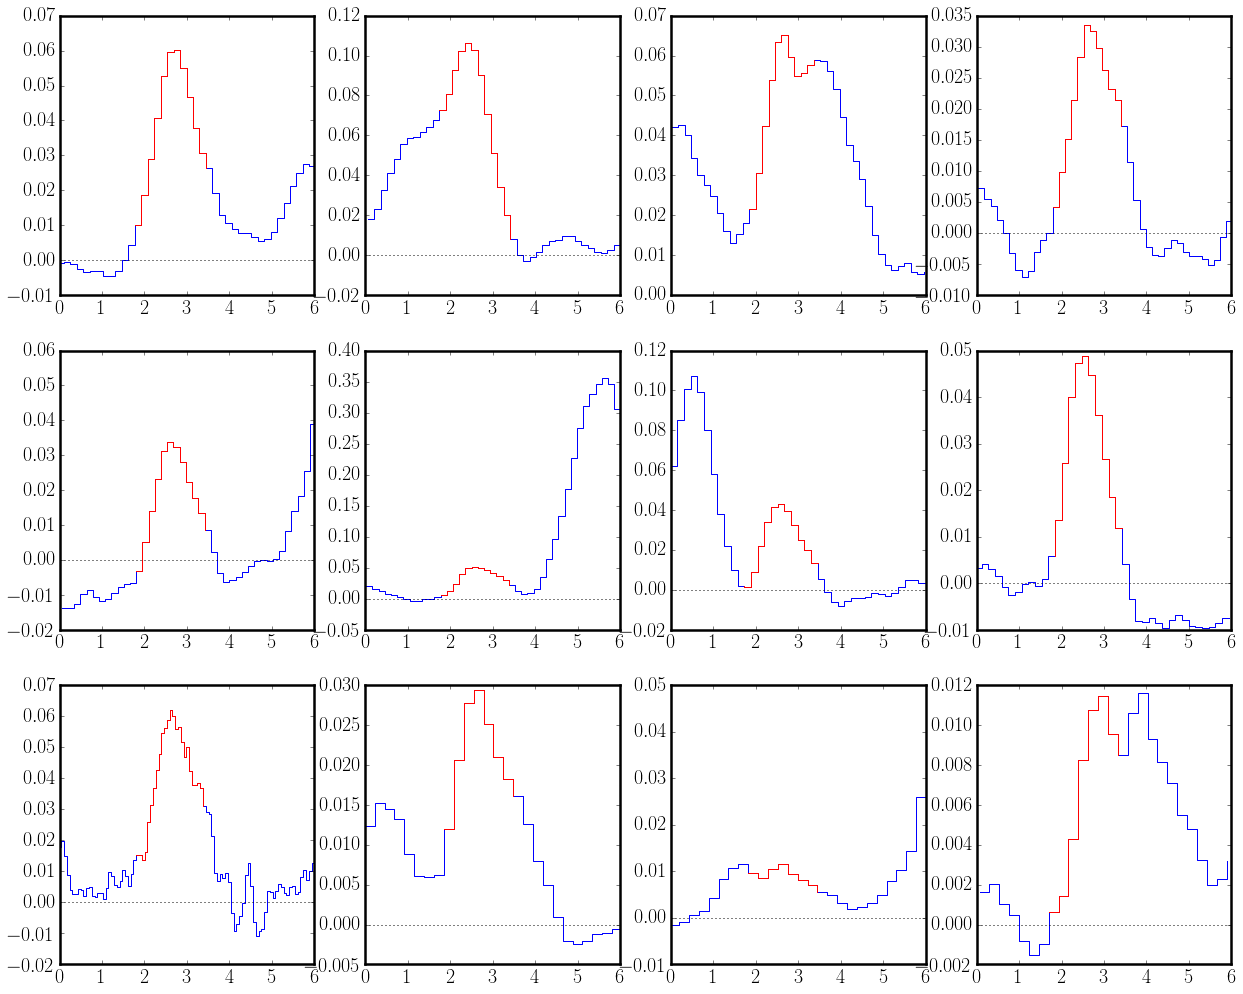

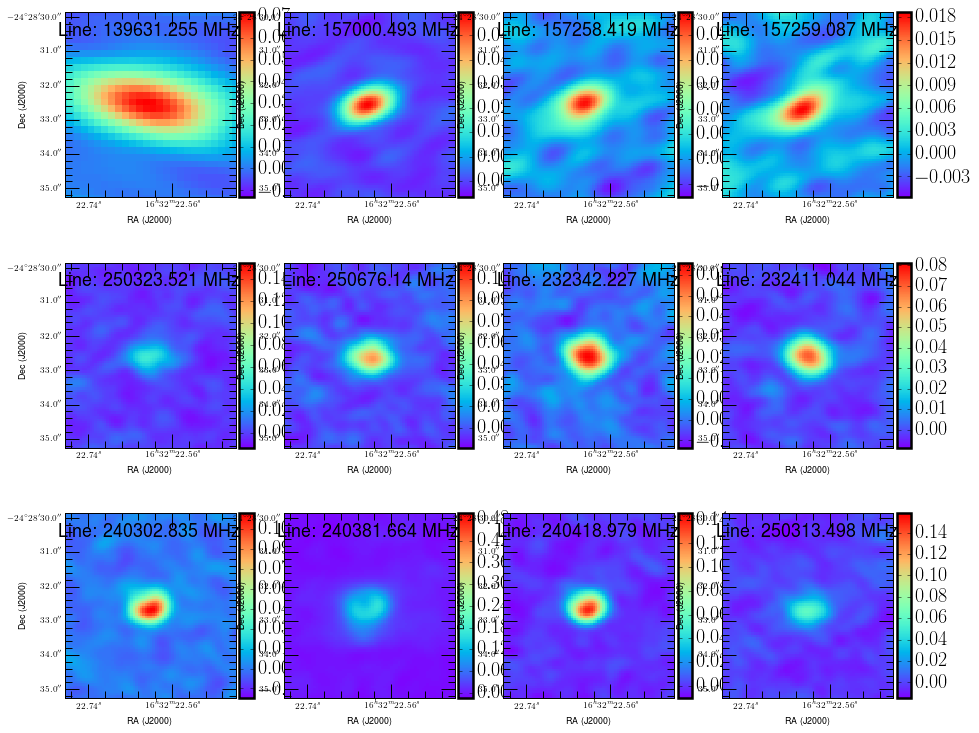

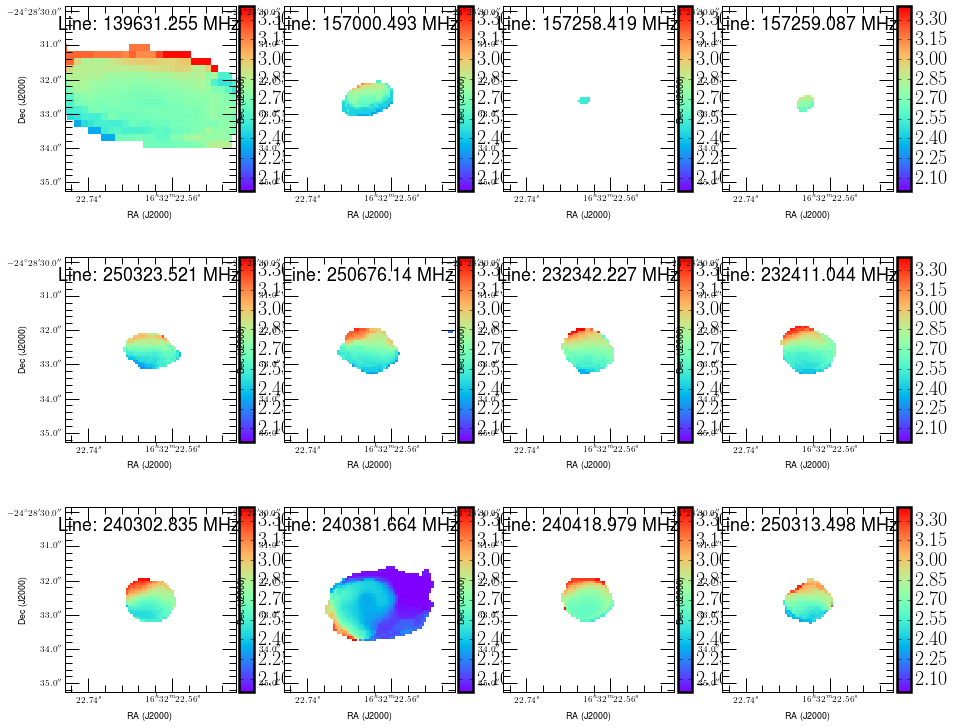

In [9]:
#
nplots = len(matched_transcube)
plot_a = False
plotmom=True

siz=5.
colormap = 'rainbow'
hh=0.5/4.
ll=0.5/3.
fig_FOV=[siz/3600.,siz/3600.]
fontsize=9
fig_center=[source_b.ra.deg,source_b.dec.deg]
print('center: {0}'.format(fig_center))
print('   fov: {0}'.format(fig_FOV))

fig_width = 21
fig_length = 17
yyp = 4
xxp = 3
fig1, ax1 = plt.subplots(xxp, yyp, sharex=False, sharey=False, squeeze=False, figsize=(fig_width,fig_length))
if plotmom:
    fig1i = plt.figure(figsize=(fig_width, fig_length))
    fig1v = plt.figure(figsize=(fig_width, fig_length))
if plot_a:
    fig2, ax2 = plt.subplots(xxp, yyp, sharex=False, sharey=False, squeeze=True, figsize=(fig_width,fig_length)) 
vmin = 0.*u.km/u.s
vmax = 6.*u.km/u.s
vimin = 1.8*u.km/u.s
vimax = 3.4*u.km/u.s
yoff=0.
plnu=False
xp = 0
yp = 0
for ip in range(nplots):
    mycube = matched_transcube[ip][0]
    myrestfreq = matched_transcube[ip][1]
    print("Using: {0}, {1}".format(mycube,myrestfreq))
    cube = SpectralCube.read(mycube)
    sca = cube.subcube_from_ds9region(a_reg)
    scag = sca.with_spectral_unit(u.GHz)
    scb = cube.subcube_from_ds9region(b_reg)
    scbg = scb.with_spectral_unit(u.GHz)
    #
    # Spectrum
    # set limits
    if plnu:
        numin = restfreq[ip]*(1.-vmin/c)
        numax = restfreq[ip]*(1.-vmax/c)
        subcube = cube.spectral_slab(numin,numax)
        subcubea = cube.spectral_slab(numin,numax)
    else:
        cubev = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=myrestfreq.to(u.MHz))
        scbv = scbg.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=myrestfreq.to(u.MHz))
        scav = scag.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=myrestfreq.to(u.MHz))
        #print("vmin={0} vamax={1} nn={2}".format(vmin,vmax,restfreq[ip].to(u.MHz)))
        #print("scbv.spectral_axis={0}".format(scbv.spectral_axis))
        subcube = scbv.spectral_slab(vmin,vmax)
        subcubea = scav.spectral_slab(vmin,vmax)
    # Get spectrum
    spec = subcube.mean(axis=(1,2))
    speca = subcubea.mean(axis=(1,2))
    # plotit
    if plnu:
        ax1[xp,yp].step((spec.spectral_axis*u.Hz).to(u.GHz).value,spec.value+yoff,color='b')
        ax1[xp,yp].plot([(numin.to(u.GHz)).value,(numax.to(u.GHz)).value],[0.,0.],color='k',linestyle='dotted')
        ax1[xp,yp].set_xlim((numin.to(u.GHz)).value,(numax.to(u.GHz)).value)
        if plot_a:
            ax2[xp,yp].step((speca.spectral_axis*u.Hz).to(u.GHz).value,speca.value+yoff,color='b')
            ax2[xp,yp].plot([(numin.to(u.GHz)).value,(numax.to(u.GHz)).value],[0.,0.],color='k',linestyle='dotted')
            ax2[xp,yp].set_xlim((numin.to(u.GHz)).value,(numax.to(u.GHz)).value)
    else:
        ax1[xp,yp].step(subcube.spectral_axis,spec.value+yoff,color='b')
        ax1[xp,yp].plot([vmin.value,vmax.value],[0.,0.],color='k',linestyle='dotted')
        ax1[xp,yp].set_xlim(vmin.value,vmax.value)
        if plot_a:
            ax2[xp,yp].step(subcubea.spectral_axis,speca.value+yoff,color='b')
            ax2[xp,yp].plot([vmin.value,vmax.value],[0.,0.],color='k',linestyle='dotted')
            ax2[xp,yp].set_xlim(vmin.value,vmax.value)
    #
    # Integrated image
    # set limits
    if plnu:
        numin = restfreq[ip]*(1.-vimin/c)
        numax = restfreq[ip]*(1.-vimax/c)
        subcube = scbg.spectral_slab(numin,numax)
        subcubea = scag.spectral_slab(numin,numax)
    else:
        subcube = scbv.spectral_slab(vimin,vimax)
        subcubea = scav.spectral_slab(vimin,vimax)
    # get spectrum
    spec = subcube.mean(axis=(1,2))
    speca = subcubea.mean(axis=(1,2))
    # plotit
    if plnu:
        ax1[xp,yp].step((spec.spectral_axis*u.Hz).to(u.GHz).value,spec.value+yoff,color='r')
        if plot_a:
            ax2[xp,yp].step((speca.spectral_axis*u.Hz).to(u.GHz).value,speca.value+yoff,color='r')
    else:
        ax1[xp,yp].step(subcube.spectral_axis.value,spec.value+yoff,color='r')
        if plot_a:
            ax2[xp,yp].step(subcubea.spectral_axis.value,speca.value+yoff,color='r')
    if plotmom:
        subcube = cubev.spectral_slab(vimin,vimax)
        fnam0 = mycube[0:-5]+'_'+str(myrestfreq.value)[0:-4]+'_m0.fits'
        fnam1 = mycube[0:-5]+'_'+str(myrestfreq.value)[0:-4]+'_m1.fits'
        fnam2 = mycube[0:-5]+'_'+str(myrestfreq.value)[0:-4]+'_m2.fits'
        myimg0 = subcube.moment(order=0)        
        txt='Line: '+str(myrestfreq.value)+' MHz'
        mask_mom=subcube>15*u.mJy
        myimg1 = (subcube.with_mask(mask_mom)).moment(order=1)    
        myimg2 = (subcube.with_mask(mask_mom)).moment(order=2) 
        os.system('rm '+fnam0+' '+fnam1+' '+fnam2)
        myimg0.write(fnam0, format='fits')
        myimg1.write(fnam1, format='fits')
        myimg2.write(fnam2, format='fits')
        #myimg1 = subcube.moment(order=1)    
        #myimg2 = subcube.moment(order=2) 
        xx=0.08+xp*(ll+0.038)
        yy=0.08+yp*(hh+0.02)
        location = [yy,xx,hh,ll]
        mydata = aiof.getdata(fnam0)
        m0min, m0max = mydata.min(), mydata.max()
        mydata = aiof.getdata(fnam1)
        m1min, m1max = 2.0, 3.4
        #print('center: {0}'.format(fig_center))
        #print('   fov: {0}'.format(fig_FOV))
        fig_map=draw_panel(fnam0, fig1i, location, colormap, m0min, m0max, fig_center, fig_FOV, fontsize=fontsize, text=txt)
        fig_map_v=draw_panel(fnam1, fig1v, location, colormap, m1min, m1max, fig_center, fig_FOV, fontsize=fontsize, text=txt)
        #ax[ip,1] = aplpy.FITSFigure(moment_0.hdu)
        #subfig = aplpy.FITSFigure(myimg0.hdu, figure=fig) #, axis=ax[ip,1])
        #subfig.show_grayscale()
        #ax[ip,1].show_colorscale()
        #
        yp = yp+1
        if (yp>=yyp):
            yp = 0
            xp = xp+1